<a href="https://colab.research.google.com/github/slipaway/melonplaylist/blob/%EC%84%B1%ED%99%98/Word2vec_%EB%AA%B0%EB%B9%B5%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 2.13 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
--

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta, datetime
import glob
import os
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
from typing import *
from khaiii import KhaiiiApi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
folder = '/content/gdrive/My Drive/melon'
filelist = os.chdir(folder)

In [6]:
genre_gn_all=pd.read_json('genre_gn_all.json', typ='series')
train=pd.read_json('train.json')
song_meta=pd.read_json('song_meta.json')

In [7]:
!git clone https://github.com/slipaway/melonplaylist.git

fatal: destination path 'melonplaylist' already exists and is not an empty directory.


In [8]:
genre_gn_all.head()

GN0100       발라드
GN0101    세부장르전체
GN0102       '80
GN0103       '90
GN0104       '00
dtype: object

In [9]:
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [10]:
gnr_code=genre_gn_all[genre_gn_all['gnr_code'].str[-2:]=='00']

In [11]:
#대장르 장르코드 리스트
gnr_code

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [12]:
#곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출

song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

#unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))),
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

#unnested 데이터프레임 생성 : song_gnr_map

song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns=song_gnr_map.columns)
song_gnr_map['id']=song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns={'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace=True)

#unnest 객체 제거
del song_gnr_map_unnest

In [13]:
plylst_date = train[['updt_date', 'songs']]
plylst_date_unnest = np.dstack(
    (
        np.repeat(plylst_date.updt_date.values, list(map(len, plylst_date.songs))), 
        np.concatenate(plylst_date.songs.values)
    )
)
plylst_date = pd.DataFrame(data=plylst_date_unnest[0], columns = plylst_date.columns)

del plylst_date_unnest

In [14]:
plylst_date["updt_date"] = plylst_date["updt_date"].map(lambda x: x[:4] + x[5:7] + x[8:10])
song_date = song_meta[["id","issue_date"]]
plylst_song_date = pd.merge(plylst_date, song_date, left_on="songs", right_on="id", how='left')
plylst_song_date["issue_date"] = plylst_song_date["issue_date"].astype(str)

plylst_song_date["strange"] = plylst_song_date["updt_date"] < plylst_song_date["issue_date"]
strange_songs = plylst_song_date[plylst_song_date["strange"] == True].drop('songs', axis=1)

In [15]:
strange_songs

,updt_date,id,issue_date,strange
180,20170915,418694,20180511,True
183,20170915,135950,20180420,True
184,20170915,304687,20180612,True
679,20131017,563802,20161202,True
712,20180102,418694,20180511,True
...,...,...,...,...
5284490,20170414,55899,20170616,True
5285431,20151230,668736,20170601,True
5285478,20151230,91908,20180824,True
5285484,20151230,240770,20180824,True


In [16]:
strange_songs=strange_songs.drop_duplicates(['id'])
len(strange_songs)

2972

In [17]:
strange_songs_list=strange_songs['id'].values.astype(str)
strange_song_gnr_map=song_gnr_map[song_gnr_map['song_id'].isin(strange_songs_list)]

In [76]:
type(strange_songs_list)

numpy.ndarray

In [69]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [68]:
strange_song_gnr_map

,song_id,gnr_code
170,153,GN1100
324,289,GN0400
544,492,GN1900
587,532,GN0400
881,787,GN0900
...,...,...
800419,705837,GN0900
800534,705941,GN0900
801388,706703,GN1000
802157,707369,GN0900


In [18]:
strange_cnt=strange_song_gnr_map.groupby('gnr_code').count()
strange_cnt=pd.merge(strange_cnt, gnr_code, on='gnr_code')

In [19]:
strange_cnt

,gnr_code,song_id,gnr_name
0,GN0100,175,발라드
1,GN0200,46,댄스
2,GN0300,80,랩/힙합
3,GN0400,47,R&B/Soul
4,GN0500,106,인디음악
5,GN0600,64,록/메탈
6,GN0700,14,성인가요
7,GN0800,34,포크/블루스
8,GN0900,760,POP
9,GN1000,491,록/메탈


In [20]:
strange_songs=strange_songs.drop_duplicates(['id'])
print(strange_songs)

        updt_date      id issue_date  strange
180      20170915  418694   20180511     True
183      20170915  135950   20180420     True
184      20170915  304687   20180612     True
679      20131017  563802   20161202     True
934      20160510  306385   20180808     True
...           ...     ...        ...      ...
5264610  20180119  123443   20180209     True
5268374  20100513  663564   20100519     True
5274802  20190824  139433   20191011     True
5278046  20140808  486629   20161202     True
5283397  20060407  398250   20060408     True

[2972 rows x 4 columns]


In [21]:
strange_id=strange_songs.loc[:, 'id']
strange_id
strange_id_list=list(strange_id)

In [22]:
train_id=train.loc[:, 'id']

In [23]:
song_meta_id=song_meta.loc[:, 'id']
print(song_meta_id.head())

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64


In [24]:
strange_songs

,updt_date,id,issue_date,strange
180,20170915,418694,20180511,True
183,20170915,135950,20180420,True
184,20170915,304687,20180612,True
679,20131017,563802,20161202,True
934,20160510,306385,20180808,True
...,...,...,...,...
5264610,20180119,123443,20180209,True
5268374,20100513,663564,20100519,True
5274802,20190824,139433,20191011,True
5278046,20140808,486629,20161202,True


In [25]:
#플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map=train[['id', 'songs']]

#unnest songs

plylst_song_map_unnest=np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))),
        np.concatenate(plylst_song_map.songs.values)
    )
)

#unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map=pd.DataFrame(data=plylst_song_map_unnest[0], columns=plylst_song_map.columns)
plylst_song_map['id']=plylst_song_map['id'].astype(str)
plylst_song_map['songs']=plylst_song_map['songs'].astype(str)

del plylst_song_map_unnest

In [26]:
#플레이리스트에 수록된 곡의 총 개수(중복 포함)

len(plylst_song_map)

5285871

In [27]:
#플레이리스트에 strange 곡 제거한 후, 수록된 곡의 총 개수(중복 포함)

plylst_song_map_remove=plylst_song_map[np.logical_not(plylst_song_map.songs.isin(strange_songs_list))]
plylst_song_map_remove.shape

(5147815, 2)

In [28]:
plylst_song_map_remove

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285865,100389,523731
5285866,100389,111365
5285868,100389,640239
5285869,100389,13759


In [29]:
#train set에 새로운 column : remove_songs 생성
#remove_songs : strange 곡 제거한 후 다시 만든 플레이리스트

plylst_song_group=plylst_song_map_remove.groupby('id')['songs'].apply(list).reset_index(name='remove_songs')
train['id']=train['id'].astype(str)
train_remove = pd.merge(train, plylst_song_group)

train_remove.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,remove_songs
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[525514, 129701, 383374, 562083, 297861, 13954..."
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[432406, 675945, 497066, 120377, 389529, 24427..."
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[83116, 276692, 166267, 186301, 354465, 256598..."
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[394031, 195524, 540149, 287984, 440773, 10033..."
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[159327, 553610, 5130, 645103, 294435, 100657,..."


In [30]:
def re_sub(series: pd.Series) -> pd.Series:
  series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True) #ㅋ 제거용
  series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True) #특수문자 제거용
  series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True) #공백 제거
  series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True) #u3000제거
  return series

def flatten(list_of_list : List) -> List:
  flatten = [j for i in list_of_list for j in i]
  return flatten

def get_token(title: str, tokenizer)-> List[Tuple]:

  if len(title)==0 or title== ' ' : #제목이 공백인 경우 tokenizer 에러 발생
    return []
  
  result = tokenizer.analyze(title)
  result = [(morph.lex, morph.tag) for split in result for morph in split.morphs] # (형태소, 품사) 튜플의 리스트
  return result

def get_all_tags(df) -> List:
  tag_list = df['tags'].values.tolist()
  tag_list=flatten(tag_list)
  return tag_list


In [31]:
tokenizer = KhaiiiApi()
all_tag = get_all_tags(train)
token_tag = [get_token(x, tokenizer) for x in all_tag] #태그를 형태소 분석

In [32]:
token_tag[:10]

[[('락', 'MAG')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('까페', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('연말', 'NNG')],
 [('눈', 'NNG'), ('오', 'VV'), ('는', 'ETM'), ('날', 'NNG')],
 [('캐럴', 'NNG')],
 [('분위기', 'NNG')],
 [('따듯', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')]]

In [33]:
token_itself=list(filter(lambda x: len(x)==1, token_tag)) # 태그 자체가 형태소여서 분리되지 않는 태그만 고름
token_itself=flatten(token_itself)
flatten_token=flatten(token_tag)

In [34]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     476,331
# of morpheme itself is  333,093
# of total token is      722,860


In [35]:
#counting part of speech (pos)
pos=[x[1] for x in token_itself]
pos_count=Counter(pos)
popular_pos = pos_count.most_common()

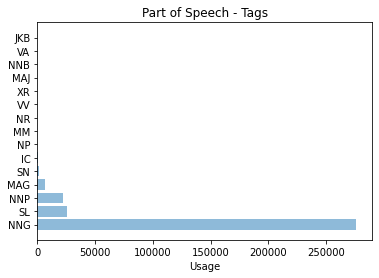

In [36]:
#tag 분류표
objects=[x[0] for x in popular_pos]
y_pos=np.arange(len(objects))
performance=[x[1] for x in popular_pos]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')
plt.show()

In [37]:
#플레이리스트 제목 형태소 분석

train['plylst_title']=re_sub(train['plylst_title'])
train.loc[:, 'ply_token']=train['plylst_title'].map(lambda x: get_token(x, tokenizer))

In [38]:
using_pos=['NNG', 'SL', 'NNP', 'MAG', 'SN'] #일반 명사, 외국어, 고유 명사, 일반 부사, 숫자
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))


In [39]:
unique_tag=set(token_itself)
unique_word=[x[0] for x in unique_tag]

#train 데이터의 plylst title 형태소 분리

In [40]:
#정답 tag에 나온 형태소만 남겨두기
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
train.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]"
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]"
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]"
5,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,"[(2017, SN), (Pop, SL)]"
6,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]",45339,짝사랑고백사랑이별슬픔 감성을 자극하는곡들,"[528130, 505036, 398947, 627363, 37748, 376358...",24,2016-10-24 21:30:17.000,"[(짝사랑, NNG), (감성, NNG), (자극, NNG), (곡, NNG)]"
7,"[잔잔한, 추억, 회상]",36557,멍청이 내맘도 몰라,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,"[(맘, NNG)]"
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOONLIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,"[(01, SN)]"
9,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]",10288,록메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,"[(록메탈, NNP), (이일우, NNP)]"


In [41]:
train_eda = pd.merge(train, plylst_song_group)
train_eda

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token,remove_songs
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]","[525514, 129701, 383374, 562083, 297861, 13954..."
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]","[432406, 675945, 497066, 120377, 389529, 24427..."
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]","[83116, 276692, 166267, 186301, 354465, 256598..."
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]","[394031, 195524, 540149, 287984, 440773, 10033..."
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]","[159327, 553610, 5130, 645103, 294435, 100657,..."
...,...,...,...,...,...,...,...,...
115058,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL ESM 2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"[(2, SN)]","[429629, 441511, 612106, 516359, 691768, 38714..."
115059,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,"[(따끈따끈, MAG), (최신, NNG), (인기, NNG), (EDM, SL),...","[321330, 216057, 534472, 240306, 331098, 23288..."
115060,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,1 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"[(1, SN), (눈물, NNG)]","[50512, 249024, 250608, 371171, 229942, 694943..."
115061,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"[(퇴근, NNG), (버스, NNG), (하루, NNG), (마무리, NNG)]","[533534, 608114, 343608, 417140, 609009, 30217..."


In [42]:
wv_sent = train_eda[['ply_token', 'tags', 'remove_songs']]
wv_sent

,ply_token,tags,remove_songs
0,"[(여행, NNG), (음악, NNG)]",[락],"[525514, 129701, 383374, 562083, 297861, 13954..."
1,"[(요즘, NNG), (말, NNG)]","[추억, 회상]","[432406, 675945, 497066, 120377, 389529, 24427..."
2,"[(곡, NNG)]","[까페, 잔잔한]","[83116, 276692, 166267, 186301, 354465, 256598..."
3,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]","[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...","[394031, 195524, 540149, 287984, 440773, 10033..."
4,"[(추억, NNG), (노래, NNG)]",[댄스],"[159327, 553610, 5130, 645103, 294435, 100657,..."
...,...,...,...
115058,"[(2, SN)]","[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]","[429629, 441511, 612106, 516359, 691768, 38714..."
115059,"[(따끈따끈, MAG), (최신, NNG), (인기, NNG), (EDM, SL),...",[일렉],"[321330, 216057, 534472, 240306, 331098, 23288..."
115060,"[(1, SN), (눈물, NNG)]","[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]","[50512, 249024, 250608, 371171, 229942, 694943..."
115061,"[(퇴근, NNG), (버스, NNG), (하루, NNG), (마무리, NNG)]","[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]","[533534, 608114, 343608, 417140, 609009, 30217..."


In [43]:
#Word2vec 이용을 위해 ply_token data를 전처리
z = []
y = []
for i in range(len(wv_sent['ply_token'])):
  z = []
  for j in range(len(wv_sent['ply_token'][i])):
    x = wv_sent['ply_token'][i][j]
    x = list(x)
    del x[1]
    z.insert(j,"".join(x))
  y.insert(i,z)
y

[['여행', '음악'],
 ['요즘', '말'],
 ['곡'],
 ['크리스마스', '분위기', '흠뻑'],
 ['추억', '노래'],
 ['2017', 'Pop'],
 ['짝사랑', '감성', '자극', '곡'],
 ['맘'],
 ['01'],
 ['록메탈', '이일우'],
 ['걸그룹'],
 ['노래', '의지', '1', '1', '짐', '프로'],
 ['제목', '편지', '준비'],
 ['트렌디', '그루브', '힙합', '알앤비'],
 ['Jazz'],
 ['걍', '음악'],
 ['노래'],
 [],
 ['비', '날', '생각'],
 ['올림픽', '스밍', '목록'],
 ['조용히', '맥주', '한잔'],
 [],
 ['추억', '명화', '시간', '영화', 'OST', '모음'],
 ['기분', '여름날'],
 ['하루', '끝', '추천', '인디곡'],
 ['새벽', '찬바람', '침대위'],
 ['기분', '햇살', '명곡'],
 ['사랑', '남녀', '듀엣'],
 [],
 ['8', 'Playlist'],
 ['스타', '미국', '대표', '클래식'],
 ['겨울', '미리'],
 ['아침', '빅', '드'],
 ['길', '음', '함께'],
 ['하우스', '2'],
 ['프로', '포', '음악'],
 [],
 ['운동', '시작'],
 ['드', '감성'],
 ['크리스마스', '캐롤', '모음'],
 ['음악'],
 ['트렌디', 'Pop', 'Music'],
 ['우리나라', '라디오', '명곡'],
 ['영화', 'Jazz'],
 ['우울', '시크'],
 ['우울'],
 ['밴드', '모음', '집'],
 ['휴일', '혼자', '시간', '2'],
 ['1'],
 ['여자', '힙합'],
 ['그', '센스', '음악'],
 [],
 ['노래'],
 ['책', '함께', '편안', '연주곡'],
 ['달', '인디', '포', '크', '2018', '06'],
 ['가슴', '사랑', '노래'],
 ['D

In [44]:
wv_sent['ply_token_new'] = y
wv_sent = wv_sent[['ply_token_new', 'tags', 'remove_songs']]
wv_sent # Word2vec 이용을 위해 필요한 data들만 모아둔 dataframe

,ply_token_new,tags,remove_songs
0,"[여행, 음악]",[락],"[525514, 129701, 383374, 562083, 297861, 13954..."
1,"[요즘, 말]","[추억, 회상]","[432406, 675945, 497066, 120377, 389529, 24427..."
2,[곡],"[까페, 잔잔한]","[83116, 276692, 166267, 186301, 354465, 256598..."
3,"[크리스마스, 분위기, 흠뻑]","[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...","[394031, 195524, 540149, 287984, 440773, 10033..."
4,"[추억, 노래]",[댄스],"[159327, 553610, 5130, 645103, 294435, 100657,..."
...,...,...,...
115058,[2],"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]","[429629, 441511, 612106, 516359, 691768, 38714..."
115059,"[따끈따끈, 최신, 인기, EDM, 모음]",[일렉],"[321330, 216057, 534472, 240306, 331098, 23288..."
115060,"[1, 눈물]","[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]","[50512, 249024, 250608, 371171, 229942, 694943..."
115061,"[퇴근, 버스, 하루, 마무리]","[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]","[533534, 608114, 343608, 417140, 609009, 30217..."


In [45]:
train_token_list = np.dstack(
    (
        np.concatenate(wv_sent.ply_token_new.values)
    )
)
train_token_list = pd.DataFrame(train_token_list[0][0], columns = ['token'])
train_token_list = list(train_token_list['token']) # train data에 존재하는 모든 플레이리스트 제목 형태소들의 list

train_tag_list = np.dstack(
    (
        np.concatenate(wv_sent.tags.values)
    )
)
train_tag_list = pd.DataFrame(train_tag_list[0][0], columns = ['tag'])
train_tag_list = list(train_tag_list['tag']) # train data에 존재하는 모든 태그들의 list

train_song_list = np.dstack(
    (
        np.concatenate(wv_sent.remove_songs.values)
    )
)
train_song_list = pd.DataFrame(train_song_list[0][0], columns = ['song'])
train_song_list = list(train_song_list['song']) # train data에 존재하는 노래들의 list

In [46]:
train_token_list


['여행',
 '음악',
 '요즘',
 '말',
 '곡',
 '크리스마스',
 '분위기',
 '흠뻑',
 '추억',
 '노래',
 '2017',
 'Pop',
 '짝사랑',
 '감성',
 '자극',
 '곡',
 '맘',
 '01',
 '록메탈',
 '이일우',
 '걸그룹',
 '노래',
 '의지',
 '1',
 '1',
 '짐',
 '프로',
 '제목',
 '편지',
 '준비',
 '트렌디',
 '그루브',
 '힙합',
 '알앤비',
 'Jazz',
 '걍',
 '음악',
 '노래',
 '비',
 '날',
 '생각',
 '올림픽',
 '스밍',
 '목록',
 '조용히',
 '맥주',
 '한잔',
 '추억',
 '명화',
 '시간',
 '영화',
 'OST',
 '모음',
 '기분',
 '여름날',
 '하루',
 '끝',
 '추천',
 '인디곡',
 '새벽',
 '찬바람',
 '침대위',
 '기분',
 '햇살',
 '명곡',
 '사랑',
 '남녀',
 '듀엣',
 '8',
 'Playlist',
 '스타',
 '미국',
 '대표',
 '클래식',
 '겨울',
 '미리',
 '아침',
 '빅',
 '드',
 '길',
 '음',
 '함께',
 '하우스',
 '2',
 '프로',
 '포',
 '음악',
 '운동',
 '시작',
 '드',
 '감성',
 '크리스마스',
 '캐롤',
 '모음',
 '음악',
 '트렌디',
 'Pop',
 'Music',
 '우리나라',
 '라디오',
 '명곡',
 '영화',
 'Jazz',
 '우울',
 '시크',
 '우울',
 '밴드',
 '모음',
 '집',
 '휴일',
 '혼자',
 '시간',
 '2',
 '1',
 '여자',
 '힙합',
 '그',
 '센스',
 '음악',
 '노래',
 '책',
 '함께',
 '편안',
 '연주곡',
 '달',
 '인디',
 '포',
 '크',
 '2018',
 '06',
 '가슴',
 '사랑',
 '노래',
 'DJ',
 '팝뮤직',
 '2',
 '사무실',
 '공기',
 '이별',
 '후',


In [47]:
train_tag_list


['락',
 '추억',
 '회상',
 '까페',
 '잔잔한',
 '연말',
 '눈오는날',
 '캐럴',
 '분위기',
 '따듯한',
 '크리스마스캐럴',
 '겨울노래',
 '크리스마스',
 '겨울왕국',
 '크리스마스송',
 '댄스',
 '운동',
 '드라이브',
 'Pop',
 '트로피컬하우스',
 '힐링',
 '기분전환',
 '2017',
 '팝',
 '트렌드',
 '일렉',
 '짝사랑',
 '취향저격',
 '슬픔',
 '고백',
 '사랑',
 '이별',
 '잔잔한',
 '추억',
 '회상',
 '일렉트로니카',
 '포크',
 '메탈',
 '락',
 '댄스',
 '인디',
 '록',
 'Metal',
 '이일우',
 'M에센셜',
 '메탈',
 'Rock',
 '락',
 'kpop',
 '댄스',
 '걸그룹댄스',
 '스트레스해소',
 '새해',
 '여행',
 '프로필음악',
 '카카오톡',
 '기분전환',
 '소원',
 '프로필',
 '소망',
 '다짐',
 '카톡',
 '듣고',
 '우울',
 '힐링',
 '이거',
 '힘내',
 '힙합',
 '느낌있는',
 '밤',
 '새벽',
 'RnB',
 '감각적인',
 '드라이브',
 '국내',
 '그루브한',
 '가을',
 '재즈',
 '락',
 '감성',
 '질리지않는',
 '나만알고싶은',
 'Pop',
 '봄',
 '설렘',
 '사랑',
 '비오는날',
 '누군가생각날때',
 '스밍',
 '목록',
 '폐막식',
 '올림픽',
 '엑소',
 '조용히',
 '혼자',
 '또는',
 '새벽감성',
 '고민',
 '맥주한잔',
 '카페',
 '재즈',
 '잔잔한',
 'OST',
 '댄스',
 '감성',
 '어쿠스틱',
 '잔잔한',
 '새벽',
 '편안한',
 '인디',
 '밤',
 '잔잔한',
 '밤',
 '새벽',
 '힐링',
 '드라이브',
 '에너지',
 '인디',
 '여행',
 '듀엣',
 '취향저격',
 '달달',
 '피쳐링',
 '사랑',
 '남녀',
 '까페',
 '설렘',
 '사랑',
 '힙

In [48]:
train_song_list


['525514',
 '129701',
 '383374',
 '562083',
 '297861',
 '139541',
 '351214',
 '650298',
 '531057',
 '205238',
 '706183',
 '127099',
 '660493',
 '461973',
 '121455',
 '72552',
 '223955',
 '324992',
 '50104',
 '432406',
 '675945',
 '497066',
 '120377',
 '389529',
 '244277',
 '461062',
 '696302',
 '442765',
 '532114',
 '586541',
 '33389',
 '244000',
 '692078',
 '37741',
 '645653',
 '571802',
 '200183',
 '61435',
 '204499',
 '41749',
 '129258',
 '413920',
 '117205',
 '6546',
 '152422',
 '602724',
 '425946',
 '631268',
 '409869',
 '97749',
 '395416',
 '103741',
 '181101',
 '472144',
 '414721',
 '75801',
 '315216',
 '192882',
 '383960',
 '548636',
 '83116',
 '276692',
 '166267',
 '186301',
 '354465',
 '256598',
 '233195',
 '666852',
 '686560',
 '556426',
 '331878',
 '195141',
 '32017',
 '617795',
 '396532',
 '623704',
 '516930',
 '300104',
 '176874',
 '443513',
 '471385',
 '35784',
 '153029',
 '336743',
 '203558',
 '348801',
 '454550',
 '394031',
 '195524',
 '540149',
 '287984',
 '440773',
 

In [49]:
#Word2vec 사용을 위해 플레이리스트 별로 제목의 형태소와 태그, 단어를 한 문장으로 갖도록 전처리
w = []
for i in range(len(wv_sent)):
  w.insert(i,wv_sent['ply_token_new'][i] + wv_sent['tags'][i] + wv_sent['remove_songs'][i])
train_eda_fin = w
train_eda_fin

[['여행',
  '음악',
  '락',
  '525514',
  '129701',
  '383374',
  '562083',
  '297861',
  '139541',
  '351214',
  '650298',
  '531057',
  '205238',
  '706183',
  '127099',
  '660493',
  '461973',
  '121455',
  '72552',
  '223955',
  '324992',
  '50104'],
 ['요즘',
  '말',
  '추억',
  '회상',
  '432406',
  '675945',
  '497066',
  '120377',
  '389529',
  '244277',
  '461062',
  '696302',
  '442765',
  '532114',
  '586541',
  '33389',
  '244000',
  '692078',
  '37741',
  '645653',
  '571802',
  '200183',
  '61435',
  '204499',
  '41749',
  '129258',
  '413920',
  '117205',
  '6546',
  '152422',
  '602724',
  '425946',
  '631268',
  '409869',
  '97749',
  '395416',
  '103741',
  '181101',
  '472144',
  '414721',
  '75801',
  '315216',
  '192882',
  '383960',
  '548636'],
 ['곡',
  '까페',
  '잔잔한',
  '83116',
  '276692',
  '166267',
  '186301',
  '354465',
  '256598',
  '233195',
  '666852',
  '686560',
  '556426',
  '331878',
  '195141',
  '32017',
  '617795',
  '396532',
  '623704',
  '516930',
  '30010

In [50]:
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec
class EpochSaver(CallbackAny2Vec):
     '''Callback to save model after each epoch.'''

     def __init__(self, path_prefix):
         self.path_prefix = path_prefix
         self.epoch = 0

     def on_epoch_end(self, model):
         output_path = get_tmpfile('{}_epoch{}.model'.format(self.path_prefix, self.epoch))
         model.save(output_path)
         self.epoch += 1

class EpochLogger(CallbackAny2Vec):
     def __init__(self):
         self.epoch = 0

     def on_epoch_begin(self, model):
         print("Epoch #{} start".format(self.epoch))

     def on_epoch_end(self, model):
         print("Epoch #{} end".format(self.epoch))
         self.epoch += 1


In [51]:
from gensim.models import Word2Vec
epoch_logger = EpochLogger()
wv_model = Word2Vec(train_eda_fin, window = 10, min_count=7, workers=6, size = 400, iter=30, sg=1, callbacks=[epoch_logger])
#min_count가 클수록, size가 작을수록 시간 단축인듯(정확도는...)
#min_count = 7, size = 400, window = 10일 때 걸린 시간: 대략 반복당 2분
#window size는 10개정도가 적당하다고 함(어느정도까지는 많을수록 좋음)
#size는 10~100 정도가 적당하다고 함(차원이 클수록 오래걸리고, 차원이 높다고 항상 좋지는 않다고 함, 수십~수백 굿)
#workers는 컴터 스펙에 따라 다른데 보통 4-6
#min_count는 주로 10-100 사이인듯

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoch #14 end
Epoch #15 start
Epoch #15 end
Epoch #16 start
Epoch #16 end
Epoch #17 start
Epoch #17 end
Epoch #18 start
Epoch #18 end
Epoch #19 start
Epoch #19 end
Epoch #20 start
Epoch #20 end
Epoch #21 start
Epoch #21 end
Epoch #22 start
Epoch #22 end
Epoch #23 start
Epoch #23 end
Epoch #24 start
Epoch #24 end
Epoch #25 start
Epoch #25 end
Epoch #26 start
Epoch #26 end
Epoch #27 start
Epoch #27 end
Epoch #28 start
Epoch #28 end
Epoch #29 start
Epoch #29 end


In [52]:
learning_list = wv_model.wv.vocab.keys()

In [53]:
wv_model.wv.most_similar(positive = ['아침', '눈', '크리스마스'],topn = 100)

[('캐롤', 0.6119142770767212),
 ('겨울', 0.6026726961135864),
 ('성탄절', 0.577490508556366),
 ('산타클로스', 0.5768096446990967),
 ('화이트크리스마스', 0.5662530660629272),
 ('눈오는날', 0.5653951168060303),
 ('눈내리는날', 0.564797580242157),
 ('MerryChristmas', 0.5644136667251587),
 ('캐럴', 0.5617043972015381),
 ('캐롤연주곡', 0.556710958480835),
 ('크리스마스캐롤', 0.5560327768325806),
 ('크리스마스노래', 0.5550429821014404),
 ('크리스마스캐럴', 0.5519269704818726),
 ('겨울감성', 0.5505115389823914),
 ('크리스마스이브', 0.5467145442962646),
 ('Carol', 0.5422499179840088),
 ('크리스마스팝송', 0.5397969484329224),
 ('산타', 0.5389202833175659),
 ('xmas', 0.5387850403785706),
 ('팝캐롤', 0.5356265306472778),
 ('첫눈', 0.5356183052062988),
 ('크리스마스파티', 0.5348501801490784),
 ('케롤', 0.534645140171051),
 ('메리크리스마스', 0.5344353914260864),
 ('12월25일', 0.5299853682518005),
 ('나홀로집에', 0.5286338925361633),
 ('353541', 0.5272926092147827),
 ('겨울카페', 0.5258851647377014),
 ('캐롤모음', 0.5246913433074951),
 ('징글벨', 0.5220727920532227),
 ('Christmas', 0.5219715237617493),
 ('겨울노래추천

In [54]:
valid=pd.read_json('val.json')
valid

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000
...,...,...,...,...,...,...
23010,[잔잔한],101722,,"[75842, 26083, 244183, 684715, 500593, 508608,...",17,2015-12-17 14:06:05.000
23011,"[어머니, 힘들때, 아빠, 가족, 위로받고싶을때]",122127,,"[450275, 487671, 561031, 663944, 628672, 59121...",10,2020-04-16 21:35:44.000
23012,[],77438,,"[625875, 464051, 11657, 236393, 358186, 213435...",0,2019-03-27 15:27:40.000
23013,[],36231,,"[161094, 665833, 688145, 432735, 439938, 12665...",31,2015-11-18 11:49:09.000


In [55]:
def re_sub(series: pd.Series) -> pd.Series:
  series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True) #ㅋ 제거용
  series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True) #특수문자 제거용
  series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True) #공백 제거
  series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True) #u3000제거
  return series

def flatten(list_of_list : List) -> List:
  flatten = [j for i in list_of_list for j in i]
  return flatten

def get_token(title: str, tokenizer)-> List[Tuple]:

  if len(title)==0 or title== ' ' : #제목이 공백인 경우 tokenizer 에러 발생
    return []
  
  result = tokenizer.analyze(title)
  result = [(morph.lex, morph.tag) for split in result for morph in split.morphs] # (형태소, 품사) 튜플의 리스트
  return result

def get_all_tags(df) -> List:
  tag_list = df['tags'].values.tolist()
  tag_list=flatten(tag_list)
  return tag_list

tokenizer = KhaiiiApi()
all_tag = get_all_tags(valid)
token_tag = [get_token(x, tokenizer) for x in all_tag] #태그를 형태소 분석

token_tag[:10]


[[('비', 'NNG')],
 [('분위기', 'NNG')],
 [('컨트리', 'NNG')],
 [('서정', 'NNG'), ('적', 'XSN'), ('이', 'VCP'), ('ㄴ', 'ETM')],
 [('스트레스', 'NNG')],
 [('아침', 'NNG')],
 [('눈', 'NNG')],
 [('크리스마스', 'NNG')],
 [('EDM', 'SL')],
 [('생각', 'NNG'), ('나', 'JC')]]

In [56]:
token_itself=list(filter(lambda x: len(x)==1, token_tag)) # 태그 자체가 형태소여서 분리되지 않는 태그만 고름
token_itself=flatten(token_itself)
flatten_token=flatten(token_tag)
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')


# of original tag is      27,338
# of morpheme itself is   18,792
# of total token is       41,957


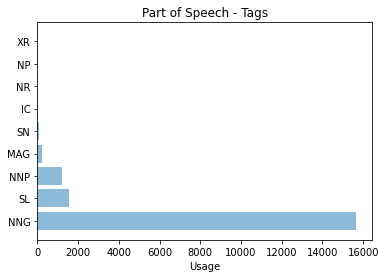

In [57]:
#counting part of speech (pos)
pos=[x[1] for x in token_itself]
pos_count=Counter(pos)
popular_pos = pos_count.most_common()
#tag 분류표
objects=[x[0] for x in popular_pos]
y_pos=np.arange(len(objects))
performance=[x[1] for x in popular_pos]
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')
plt.show()


In [58]:
#플레이리스트 제목 형태소 분석
valid['plylst_title']=re_sub(valid['plylst_title'])
valid.loc[:, 'ply_token']=valid['plylst_title'].map(lambda x: get_token(x, tokenizer))
using_pos=['NNG', 'SL', 'NNP', 'MAG', 'SN'] #일반 명사, 외국어, 고유 명사, 일반 부사, 숫자
valid['ply_token']=valid['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))
unique_tag=set(token_itself)
unique_word=[x[0] for x in unique_tag]
#train 데이터의 plylst title 형태소 분리
#정답 tag에 나온 형태소만 남겨두기
valid['ply_token']=valid['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
valid.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000,[]
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000,[]
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000,[]
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000,[]
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000,[]
5,"[비, 분위기, 컨트리, 서정적인]",138538,,"[173033, 138237, 63140, 15733, 461780, 308519,...",2,2019-06-12 17:43:35.000,[]
6,[],127575,,"[227044, 424672, 515592, 22408, 57893, 153714,...",2,2011-10-28 11:21:51.000,[]
7,[],115317,,"[54457, 423722, 337682, 91214, 644980, 556444,...",3,2014-01-26 20:00:30.000,[]
8,[스트레스],80810,리듬타면서 빡시게 운동하자스트레스 날리자,[],127,2017-02-09 17:33:45.000,"[(운동, NNG), (스트레스, NNG)]"
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000,"[(기분, NNG), (재즈, NNG), (함께, MAG), (하루, NNG)]"


In [59]:
valid

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000,[]
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000,[]
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000,[]
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000,[]
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000,[]
...,...,...,...,...,...,...,...
23010,[잔잔한],101722,,"[75842, 26083, 244183, 684715, 500593, 508608,...",17,2015-12-17 14:06:05.000,[]
23011,"[어머니, 힘들때, 아빠, 가족, 위로받고싶을때]",122127,,"[450275, 487671, 561031, 663944, 628672, 59121...",10,2020-04-16 21:35:44.000,[]
23012,[],77438,,"[625875, 464051, 11657, 236393, 358186, 213435...",0,2019-03-27 15:27:40.000,[]
23013,[],36231,,"[161094, 665833, 688145, 432735, 439938, 12665...",31,2015-11-18 11:49:09.000,[]


In [60]:
val_song=valid[['id', 'songs']]

filter=val_song['songs'].astype('str')=='[]'
val_song_remove=val_song.loc[~filter, :]

val_song_remove_unnest=np.dstack(
    (
        np.repeat(val_song_remove.id.values, list(map(len, val_song_remove.songs))),
        np.concatenate(val_song_remove.songs.values)
    )
  
)

val_song_remove=pd.DataFrame(data=val_song_remove_unnest[0], columns=val_song_remove.columns)
val_song_remove['id']=val_song_remove['id'].astype('str')
val_song_remove['songs']=val_song_remove['songs'].astype('str')

del val_song_remove_unnest

val_song_remove=val_song_remove.groupby('id')['songs'].apply(list).reset_index(name='remove_songs')

val_remove=valid[~filter]
val_remove['id']=val_remove['id'].astype('str')
val_remove=pd.merge(val_remove, val_song_remove)

val_remove

val_not_remove=valid[filter]

val_not_remove

val_remove['songs']=val_remove['remove_songs']
val_remove=val_remove.drop('remove_songs', axis=1)
val_fixed=pd.concat([val_remove, val_not_remove])
val_fixed

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000,[]
1,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000,[]
2,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000,[]
3,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000,[]
4,"[비, 분위기, 컨트리, 서정적인]",138538,,"[173033, 138237, 63140, 15733, 461780, 308519,...",2,2019-06-12 17:43:35.000,[]
...,...,...,...,...,...,...,...
22991,[],32537,컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작,[],28,2019-06-17 14:22:48.000,"[(컨트리, NNG), (황제, NNG)]"
22992,[사랑],32812,옷차림이 가벼워질때 부담없이 듣는음악,[],8,2015-05-08 00:09:01.000,"[(음악, NNG)]"
22996,[],86721,해 저무는 밤,[],5,2016-04-27 15:32:55.000,"[(밤, NNG)]"
23002,"[텐션, 명곡, 학창시절, 텐션업]",56570,숨어듣는명곡 텐션올릴때듣는 그시절그노래 그냥명곡있을수있음주의,[],538,2020-04-18 22:02:07.000,"[(텐션, NNG), (시, NNG), (그냥, MAG), (명곡, NNG)]"


In [82]:
val_sent = val_fixed[['id', 'ply_token', 'tags', 'songs']]
val_sent

,id,ply_token,tags,songs
0,118598,[],[],"[373313, 151080, 275346, 696876, 165237, 52593..."
1,51464,[],[],"[529437, 516103, 360067, 705713, 226062, 37089..."
2,45144,[],[],"[589668, 21711, 570151, 320043, 13930, 599327,..."
3,79929,[],[],"[672718, 121924, 102694, 683657, 201558, 38511..."
4,138538,[],"[비, 분위기, 컨트리, 서정적인]","[173033, 138237, 63140, 15733, 461780, 308519,..."
...,...,...,...,...
22991,32537,"[(컨트리, NNG), (황제, NNG)]",[],[]
22992,32812,"[(음악, NNG)]",[사랑],[]
22996,86721,"[(밤, NNG)]",[],[]
23002,56570,"[(텐션, NNG), (시, NNG), (그냥, MAG), (명곡, NNG)]","[텐션, 명곡, 학창시절, 텐션업]",[]


In [83]:
val_sent = val_sent.reset_index(drop=True)

In [84]:
val_sent = pd.DataFrame(val_sent)
val_sent

,id,ply_token,tags,songs
0,118598,[],[],"[373313, 151080, 275346, 696876, 165237, 52593..."
1,51464,[],[],"[529437, 516103, 360067, 705713, 226062, 37089..."
2,45144,[],[],"[589668, 21711, 570151, 320043, 13930, 599327,..."
3,79929,[],[],"[672718, 121924, 102694, 683657, 201558, 38511..."
4,138538,[],"[비, 분위기, 컨트리, 서정적인]","[173033, 138237, 63140, 15733, 461780, 308519,..."
...,...,...,...,...
23010,32537,"[(컨트리, NNG), (황제, NNG)]",[],[]
23011,32812,"[(음악, NNG)]",[사랑],[]
23012,86721,"[(밤, NNG)]",[],[]
23013,56570,"[(텐션, NNG), (시, NNG), (그냥, MAG), (명곡, NNG)]","[텐션, 명곡, 학창시절, 텐션업]",[]


In [85]:
#Word2vec 이용을 위해 ply_token data를 전처리
z = []
y = []
for i in range(len(val_sent['ply_token'])):
  z = []
  if len(val_sent['ply_token'][i]) == 0:
    x = val_sent['ply_token'][i]
    z = x
  else:
    for j in range(len(val_sent['ply_token'][i])):
     x = val_sent['ply_token'][i][j]
     z.insert(j,x[0])
  y.insert(i,z)
y

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [86]:
val_sent['ply_token_new'] = y
val_sent = val_sent[['id', 'ply_token_new', 'tags', 'songs']]
val_sent # Word2vec 이용을 위해 필요한 data들만 모아둔 dataframe


,id,ply_token_new,tags,songs
0,118598,[],[],"[373313, 151080, 275346, 696876, 165237, 52593..."
1,51464,[],[],"[529437, 516103, 360067, 705713, 226062, 37089..."
2,45144,[],[],"[589668, 21711, 570151, 320043, 13930, 599327,..."
3,79929,[],[],"[672718, 121924, 102694, 683657, 201558, 38511..."
4,138538,[],"[비, 분위기, 컨트리, 서정적인]","[173033, 138237, 63140, 15733, 461780, 308519,..."
...,...,...,...,...
23010,32537,"[컨트리, 황제]",[],[]
23011,32812,[음악],[사랑],[]
23012,86721,[밤],[],[]
23013,56570,"[텐션, 시, 그냥, 명곡]","[텐션, 명곡, 학창시절, 텐션업]",[]


In [213]:
# val_sent에서 학습된 리스트에 존재하지 않는 ply_token을 제외함
for i in range(len(val_sent['ply_token_new'])):
  if len(val_sent['ply_token_new'][i]) == 0:
    val_sent['ply_token_new'][i] = val_sent['ply_token_new'][i]
  else:
    a = pd.DataFrame(val_sent['ply_token_new'][i], columns = ['token'])
    a['logical'] = a.isin(learning_list).astype(str)
    b = a['logical'] == 'True' 
    if b.sum() == 0:
      val_sent['ply_token_new'][i] = []
    else:
      c = c = a[b].drop('logical',axis=1)
      c = c.token.tolist()
      val_sent['ply_token_new'][i] = c

# 그 이후에는 태그 10개와 곡 100개를 뽑을 수 있도록 최종함수를 만드는 것이 목표
# 이 때 반복문&조건문을 사용하며 wv.most.similar에서 topn을 조절해가면서 곡 100개와 태그 10개를 뽑아내야 함
# 각각 train_tag_list & train_song_list에 들어있는 조건을 만족하는 10&100개를 뽑는 것이 필요함.
# 그런 함수를 만들어내면 최종적으로 validation data를 전처리한 최종 데이터셋을 내가 만든 함수에 input으로 넣으면 
# 각각의 플레이리스트 id에 대해 예측 곡100개 & 예측태그 10개를 결과값으로 낼 수 있게 될 것으로 기대됨


0                     []
1                     []
2                     []
3                     []
4                     []
              ...       
23010          [컨트리, 황제]
23011               [음악]
23012                [밤]
23013    [텐션, 시, 그냥, 명곡]
23014                 []
Name: ply_token_new, Length: 23015, dtype: object

In [215]:
# val_sent에서 학습된 리스트에 존재하지 않는 tags를 제외함
for i in range(len(val_sent['tags'])):
  if len(val_sent['tags'][i]) == 0:
    val_sent['tags'][i] = val_sent['tags'][i]
  else:
    a = pd.DataFrame(val_sent['tags'][i], columns = ['tag'])
    a['logical'] = a.isin(learning_list).astype(str)
    b = a['logical'] == 'True' 
    if b.sum() == 0:
      val_sent['tags'][i] = []
    else:
      c = c = a[b].drop('logical',axis=1)
      c = c.tag.tolist()
      val_sent['tags'][i] = c
val_sent['tags']


0                                     []
1                                     []
2                                     []
3                                     []
4                    [비, 분위기, 컨트리, 서정적인]
                      ...               
23010                                 []
23011                               [사랑]
23012                                 []
23013                [텐션, 명곡, 학창시절, 텐션업]
23014    [sweetmind, 발라드, 사랑, 기분전환, 역주행]
Name: tags, Length: 23015, dtype: object

In [216]:
# val_sent에서 학습된 리스트에 존재하지 않는 songs를 제외함
for i in range(len(val_sent['songs'])):
  if len(val_sent['songs'][i]) == 0:
    val_sent['songs'][i] = val_sent['songs'][i]
  else:
    a = pd.DataFrame(val_sent['songs'][i], columns = ['song'])
    a['logical'] = a.isin(learning_list).astype(str)
    b = a['logical'] == 'True' 
    if b.sum() == 0:
      val_sent['songs'][i] = []
    else:
      c = c = a[b].drop('logical',axis=1)
      c = c.song.tolist()
      val_sent['songs'][i] = c
val_sent['songs']


0        [373313, 151080, 275346, 165237, 525935, 45781...
1         [529437, 226062, 370891, 495061, 614059, 110325]
2        [589668, 21711, 570151, 320043, 13930, 599327,...
3        [672718, 121924, 102694, 683657, 201558, 38511...
4                                                 [225090]
                               ...                        
23010                                                   []
23011                                                   []
23012                                                   []
23013                                                   []
23014                                                   []
Name: songs, Length: 23015, dtype: object

In [217]:
val_sent

,id,ply_token_new,tags,songs
0,118598,[],[],"[373313, 151080, 275346, 165237, 525935, 45781..."
1,51464,[],[],"[529437, 226062, 370891, 495061, 614059, 110325]"
2,45144,[],[],"[589668, 21711, 570151, 320043, 13930, 599327,..."
3,79929,[],[],"[672718, 121924, 102694, 683657, 201558, 38511..."
4,138538,[],"[비, 분위기, 컨트리, 서정적인]",[225090]
...,...,...,...,...
23010,32537,"[컨트리, 황제]",[],[]
23011,32812,[음악],[사랑],[]
23012,86721,[밤],[],[]
23013,56570,"[텐션, 시, 그냥, 명곡]","[텐션, 명곡, 학창시절, 텐션업]",[]


In [218]:
#Word2vec 사용을 위해 플레이리스트 별로 제목의 형태소와 태그, 단어를 한 문장으로 갖도록 전처리
w = []
for i in range(len(val_sent)):
  w.insert(i,val_sent['ply_token_new'][i] + val_sent['tags'][i] + val_sent['songs'][i])
val_input = w
val_input


[['373313',
  '151080',
  '275346',
  '165237',
  '525935',
  '457812',
  '371709',
  '170292',
  '438915',
  '162569',
  '310892',
  '608704',
  '127698',
  '269427',
  '592526',
  '368214',
  '24386',
  '104455',
  '61612',
  '151421',
  '416023'],
 ['529437', '226062', '370891', '495061', '614059', '110325'],
 ['589668',
  '21711',
  '570151',
  '320043',
  '13930',
  '599327',
  '216696',
  '170279',
  '93151',
  '455185',
  '634366',
  '277910',
  '671805',
  '622636',
  '232676',
  '442352'],
 ['672718',
  '121924',
  '102694',
  '683657',
  '201558',
  '385110',
  '610734',
  '83940'],
 ['비', '분위기', '컨트리', '서정적인', '225090'],
 ['227044', '424672', '515592', '22408', '57893', '212469'],
 ['91214',
  '411444',
  '148421',
  '380705',
  '385083',
  '560581',
  '385696',
  '543291',
  '414883',
  '221366',
  '53522',
  '255060',
  '150211',
  '184949'],
 ['362319', '38935', '119190'],
 ['아침', '눈', '크리스마스', '349494'],
 ['EDM',
  '392257',
  '668879',
  '460746',
  '490966',
  '431910'

In [ ]:
for i in range(len(val_input)

In [219]:
wv_model.wv.most_similar(positive = val_input[0],topn = 100)

[('89503', 0.8882354497909546),
 ('574308', 0.8800390958786011),
 ('394921', 0.8786777853965759),
 ('667791', 0.8752396702766418),
 ('650957', 0.8728331923484802),
 ('520540', 0.8721959590911865),
 ('139249', 0.8630251884460449),
 ('193674', 0.8597512245178223),
 ('412246', 0.8549603223800659),
 ('209684', 0.8521823287010193),
 ('70465', 0.8514831066131592),
 ('485776', 0.8474042415618896),
 ('546713', 0.8457843065261841),
 ('680970', 0.8449827432632446),
 ('410166', 0.8408490419387817),
 ('382962', 0.8361597657203674),
 ('416417', 0.8317766785621643),
 ('545816', 0.8203005790710449),
 ('590972', 0.8199055194854736),
 ('396028', 0.819744884967804),
 ('217678', 0.8072525262832642),
 ('585728', 0.8063825964927673),
 ('disney', 0.8062732219696045),
 ('421833', 0.8057651519775391),
 ('411438', 0.8053799271583557),
 ('417188', 0.8031443357467651),
 ('242188', 0.8017372488975525),
 ('76938', 0.8010871410369873),
 ('26908', 0.8000316619873047),
 ('266385', 0.7998509407043457),
 ('10690', 0.79

In [ ]:
# input: 플레이리스트 제목 or 곡 or 플레이리스트 제목&태그 or 곡&태그
wv_model.wv.most_similar('',topn = #뽑힐 개수) #input이 여러 개면 ''대신 positive=['', '', ...]

# 필요한 output: 곡 100개 & 태그 10개
# x는 ['', '', ...]의 형식
def result(x):
  if wv_model.wv.most_similar(positive=x, topn = 100)[]


while 
if 